<a href="https://colab.research.google.com/github/jordantab/11785-assignment-part2s/blob/main/HW2P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

Fri Oct 11 18:20:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.1 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
from pytorch_metric_learning import losses
import csv
from torchvision.transforms import v2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [5]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [6]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jordantab","key":"6012317c8cbe2756d1bf461f146b1d6e"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=3dc7304c8fd53dcb15673f3a0c9141ae383aa9805ea3ac5e698ef8236541fd3d
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [7]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

100% 2.75G/2.75G [00:15<00:00, 236MB/s]
100% 2.75G/2.75G [00:15<00:00, 186MB/s]


# Config

In [8]:
run_name = "convnext-t-8"

checkpoint_dir = f"/content/drive/My Drive/hw2p2/checkpoints/{run_name}"
os.makedirs(checkpoint_dir, exist_ok=True)

config = {
    'batch_size': 512, # Increase this if your GPU can handle it
    'p': 0.5,
    'degrees': 10,
    'brightness': 0.1,
    'contrast': 0.1,
    'saturation': 0.1,
    'hue': 0.05,
    'lr':  0.1,
    'factor': 0.1,
    'weight_decay': 0.1,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "data/11-785-f24-hw2p2-verification/cls_data",
    'data_ver_dir': "data/11-785-f24-hw2p2-verification/ver_data",
    'checkpoint_dir': checkpoint_dir,
    'run_name': run_name
    # Include other parameters as needed.
}

In [ ]:
print(os.path.exists('data/11-785-f24-hw2p2-verification'))

# Dataset

## Dataset Class for doing Image Verification

In [9]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [10]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [11]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112), # Why are we resizing the Image?
    torchvision.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    torchvision.transforms.RandomHorizontalFlip(p=config['p']),
    torchvision.transforms.RandomRotation(degrees=config['degrees']),
    torchvision.transforms.ColorJitter(brightness=config['brightness'], contrast=config['contrast'], saturation=config['saturation'], hue=config['hue']),
    torchvision.transforms.RandomResizedCrop(size=112, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

In [12]:
data_dir = config['data_ver_dir']

# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [13]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  512
Train batches        :  843
Val batches          :  85


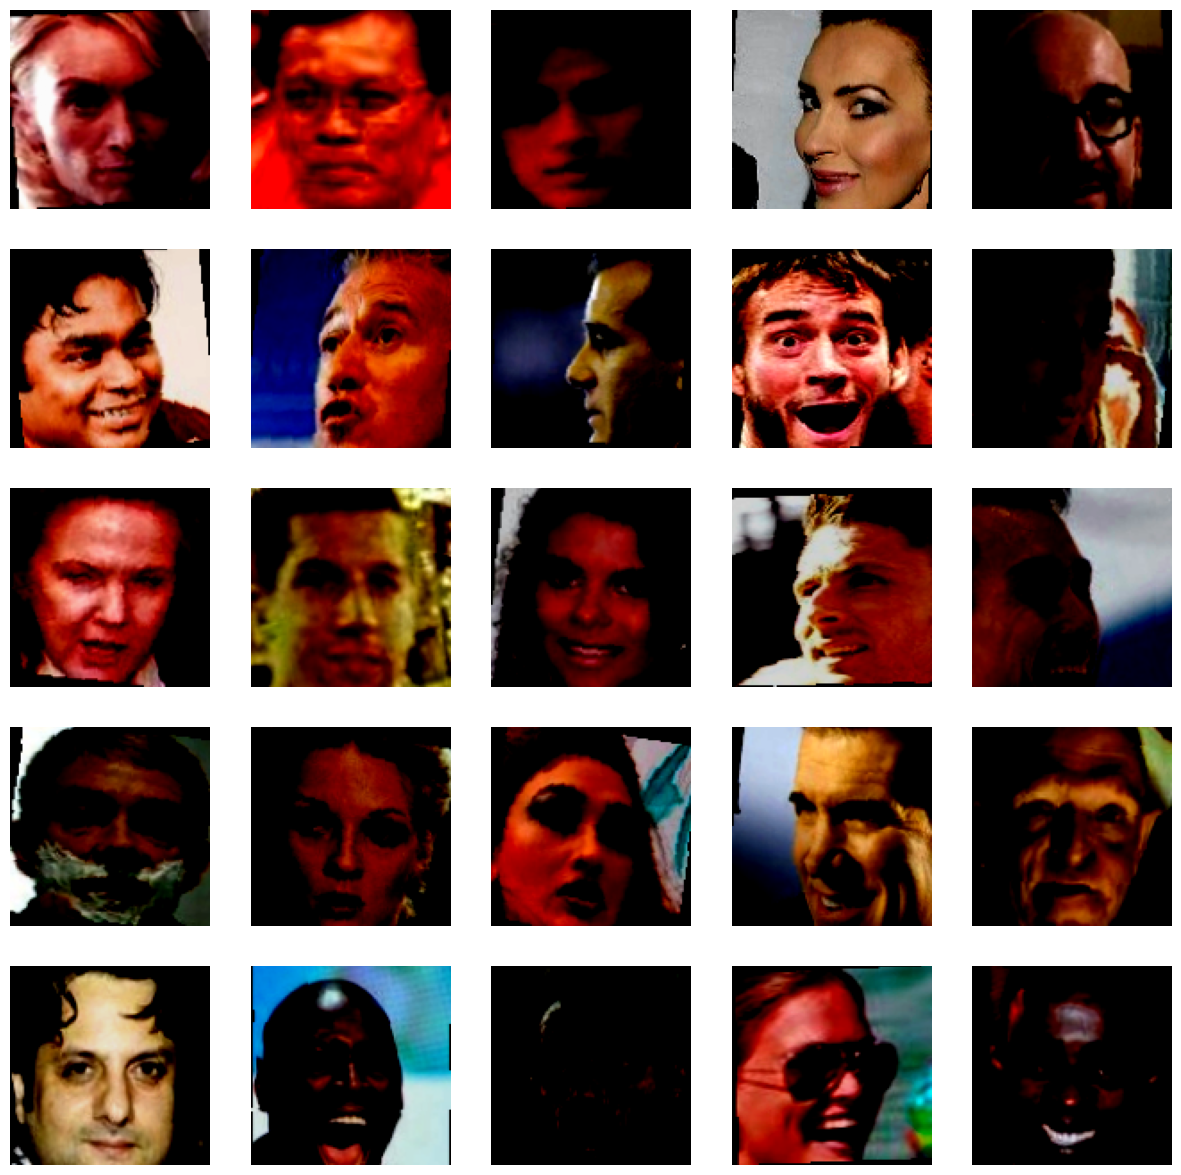

In [14]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# # Residual Block for ResNet

# class ResidualBlock(torch.nn.Module):
#   expansion = 1

#   def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#     super(ResidualBlock, self).__init__()
#     self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), torch.nn.BatchNorm2d(out_channels))
#     self.downsample = downsample
#     self.relu = torch.nn.ReLU()

#   def forward(self, x):
#     residual = x

#     # First convolutional layer
#     out = self.conv1(x)

#     # Second convolutional layer
#     out = self.conv2(out)

#     if self.downsample is not None:
#       residual = self.downsample(x)

#     out += residual
#     out = self.relu(out)

#     return out

In [ ]:
# # Residual Block for ResNet-50

# class ResidualBlock(torch.nn.Module):
#   expansion = 4

#   def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#     super(ResidualBlock, self).__init__()
#     print(in_channels, out_channels)
#     self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1), torch.nn.BatchNorm2d(out_channels * self.expansion))
#     self.downsample = downsample
#     self.relu = torch.nn.ReLU()

#   def forward(self, x):
#     residual = x

#     # First convolutional layer (bottleneck)
#     out = self.conv1(x)

#     # Second convolutional layer
#     out = self.conv2(out)

#     # Third convolutional layer
#     out = self.conv3(out)

#     if self.downsample is not None:
#       residual = self.downsample(x)

#     out += residual
#     out = self.relu(out)

#     return out

In [ ]:
# # ResNet Architecture stacking together blocks
# class ResNet(torch.nn.Module):
#   def __init__(self, block, layers, num_classes=8631):
#     super(ResNet, self).__init__()
#     self.in_channels = 64

#     # Initial convolution and pooling layers
#     self.conv1 = torch.nn.Sequential(
#       torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
#       torch.nn.BatchNorm2d(64),
#       torch.nn.ReLU())
#     self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#     # Residual blocks
#     self.layer1 = self._make_layer(block, 64, layers[0], 1)
#     self.layer2 = self._make_layer(block, 128, layers[1], 2, stride=2)
#     self.layer3 = self._make_layer(block, 256, layers[2], 3, stride=2)
#     self.layer4 = self._make_layer(block, 512, layers[3], 4, stride=2)

#     # Average pooling and fully connected layer
#     self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
#     self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

#   def _make_layer(self, block, out_channels, blocks, i, stride=1):
#     downsample = None
#     if stride != 1 or self.in_channels != out_channels * block.expansion:
#       downsample = torch.nn.Sequential(
#           torch.nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=
#                           1, stride=stride),
#           torch.nn.BatchNorm2d(out_channels * block.expansion)
#       )

#     layers = []
#     layers.append(block(self.in_channels, out_channels, stride, downsample))
#     self.in_channels = out_channels * block.expansion
#     for i in range(1, blocks):
#       layers.append(block(self.in_channels, out_channels))

#     return torch.nn.Sequential(*layers)

#   def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         feats = x
#         out = self.fc(x)

#         return {"feats": feats, "out": out}

# model = ResNet(ResidualBlock, [3,4,6,3]).to(DEVICE)
# summary(model, (3, 112, 112))

64 64
256 64
256 64
256 128
512 128
512 128
512 128
512 256
1024 256
1024 256
1024 256
1024 256
1024 256
1024 512
2048 512
2048 512
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,472
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           4,160
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,928
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,640
      BatchNorm2d-12          [-1, 

In [15]:
# Building block for ConvNeXt

class ConvNeXtBlock(nn.Module):
  def __init__(self, dim):
    super(ConvNeXtBlock, self).__init__()

    # Depthwise convolution
    self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

    # Pointwise convolutions
    self.pwconv1 = nn.Linear(dim, 4 * dim)
    self.pwconv2 = nn.Linear(4 * dim, dim)

    # Normalization and activation
    self.ln = nn.LayerNorm(dim, eps=1e-6)
    self.gelu = nn.GELU()

  def forward(self, x):
    input = x

    x = self.dwconv(x)
    x = x.permute(0, 2, 3, 1)
    x = self.ln(x)
    x = self.pwconv1(x)
    x = self.gelu(x)
    x = self.pwconv2(x)
    x = x.permute(0, 3, 1, 2)
    x = x + input

    return x

In [16]:
# Permute class

class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

In [17]:
# ConvNeXt-T architecture based on 'A ConvNet for the 2020s' (https://arxiv.org/abs/2201.03545)

class ConvNeXt(nn.Module):
  def __init__(self, in_channels=3, num_classes=8631, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]):
    super(ConvNeXt, self).__init__()

    # Downsampling layers initilization
    self.downsampling_layers = nn.ModuleList()

    # Stem layer
    stem = nn.Sequential(
        nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
        Permute(0, 2, 3, 1),
        nn.LayerNorm(dims[0], eps=1e-6),
        Permute(0, 3, 1, 2),
    )
    self.downsampling_layers.append(stem)

    # Downsampling layers
    for i in range(3):
      downsampling_layer = nn.Sequential(
          Permute(0, 2, 3, 1),
          nn.LayerNorm(dims[i], eps=1e-6),
          Permute(0, 3, 1, 2),
          nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
      )
      self.downsampling_layers.append(downsampling_layer)

    # Stages
    self.stages = nn.ModuleList()
    for i in range(4):
      stage = nn.Sequential(
          *[ConvNeXtBlock(dims[i]) for _ in range(depths[i])]
      )
      self.stages.append(stage)

    # Final normalization and classification head
    self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
    self.head = nn.Linear(dims[-1], num_classes)

  def forward(self, x):
    for i in range(4):
      # Downsample between stages
      x = self.downsampling_layers[i](x)
      x = self.stages[i](x)
    x = x.mean([-2, -1])
    feats = x
    x = self.norm(x)
    out = self.head(x)

    return {"feats": feats, "out": out}

model = ConvNeXt().to(DEVICE)
summary(model, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           4,704
           Permute-2           [-1, 28, 28, 96]               0
         LayerNorm-3           [-1, 28, 28, 96]             192
           Permute-4           [-1, 96, 28, 28]               0
            Conv2d-5           [-1, 96, 28, 28]           4,800
         LayerNorm-6           [-1, 28, 28, 96]             192
            Linear-7          [-1, 28, 28, 384]          37,248
              GELU-8          [-1, 28, 28, 384]               0
            Linear-9           [-1, 28, 28, 96]          36,960
    ConvNeXtBlock-10           [-1, 96, 28, 28]               0
           Conv2d-11           [-1, 96, 28, 28]           4,800
        LayerNorm-12           [-1, 28, 28, 96]             192
           Linear-13          [-1, 28, 28, 384]          37,248
             GELU-14          [-1, 28, 

In [19]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= config['lr'])
# optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], )
# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=config['factor'], patience=config['patience'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'], T_mult=['T_mult'])
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['epochs'], steps_per_epoch=len(train_loader))
# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-19-de74aaebbffa>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [20]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [22]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [23]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [24]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [25]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [26]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [27]:
wandb.login(key="4c68592a14802648ff3220711294d6e5fe7d272f") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [28]:
# Create your wandb run
run = wandb.init(
    name = config['run_name'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = gen_id, ### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config, ### Wandb Config for your run
)

wandb: Currently logged in as: jordantab20 (jordantab20-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


# Checkpointing and Loading Model

In [29]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [30]:
print(os.path.exists("best_cls.pth"))

False


# Load Pre-Trained Model

In [119]:
# from pytorch_metric_learning import losses
model, optimizer, scheduler, epoch, metrics = load_model(model, optimizer, scheduler, "best_ret (1).pth")

# optimizer = torch.optim.SGD(model.parameters(), lr=0.09989011473116477)

<ipython-input-117-917ec4f96c61>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


FileNotFoundError: [Errno 2] No such file or directory: 'best_ret (1).pth'

In [120]:
criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])
optimizer = torch.optim.SGD(criterion.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=config['momentum'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['epochs'], steps_per_epoch=len(train_loader))

KeyError: 'momentum'

# Experiments

In [249]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })
            scheduler.step(valid_loss)

        # retrieval validation
        valid_ret_acc, valid_eer = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc,
            'valid_eer': valid_eer,
            'lr': curr_lr
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/100: 
Train Cls. Acc 0.3367%	 Train Cls. Loss 8.1958	 Learning Rate 0.0978


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 0.8639%	 Val Cls. Loss 7.8135


{'ACC': 62.6, 'EER': 38.28920570264709, 'AUC': 66.17304006498105, 'TPRs': [('TPR@FPR=1e-4', 1.2219959266802443), ('TPR@FPR=5e-4', 1.2219959266802443), ('TPR@FPR=1e-3', 1.2219959266802443), ('TPR@FPR=5e-3', 5.7026476578411405), ('TPR@FPR=5e-2', 18.533604887983707)]}
Val Ret. Acc 62.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 2/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/100: 
Train Cls. Acc 1.2744%	 Train Cls. Loss 7.5534	 Learning Rate 0.0981


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 2.3723%	 Val Cls. Loss 7.1967


{'ACC': 65.9, 'EER': 35.16699410617329, 'AUC': 70.42281699270563, 'TPRs': [('TPR@FPR=1e-4', 4.684317718940937), ('TPR@FPR=5e-4', 4.684317718940937), ('TPR@FPR=1e-3', 4.684317718940937), ('TPR@FPR=5e-3', 4.684317718940937), ('TPR@FPR=5e-2', 25.865580448065174)]}
Val Ret. Acc 65.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/100: 
Train Cls. Acc 3.4674%	 Train Cls. Loss 6.9132	 Learning Rate 0.0984


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 5.8507%	 Val Cls. Loss 6.5196


{'ACC': 68.7, 'EER': 32.61296660127084, 'AUC': 72.38745353494534, 'TPRs': [('TPR@FPR=1e-4', 6.109979633401222), ('TPR@FPR=5e-4', 6.109979633401222), ('TPR@FPR=1e-3', 6.109979633401222), ('TPR@FPR=5e-3', 8.350305498981669), ('TPR@FPR=5e-2', 23.828920570264767)]}
Val Ret. Acc 68.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/100: 
Train Cls. Acc 7.5412%	 Train Cls. Loss 6.2380	 Learning Rate 0.0986


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 11.1354%	 Val Cls. Loss 5.8345


{'ACC': 68.7, 'EER': 31.43418467587774, 'AUC': 74.02398377074172, 'TPRs': [('TPR@FPR=1e-4', 7.739307535641547), ('TPR@FPR=5e-4', 7.739307535641547), ('TPR@FPR=1e-3', 7.739307535641547), ('TPR@FPR=5e-3', 9.368635437881874), ('TPR@FPR=5e-2', 30.95723014256619)]}
Val Ret. Acc 68.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/100: 
Train Cls. Acc 13.5088%	 Train Cls. Loss 5.5359	 Learning Rate 0.0989


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 18.7957%	 Val Cls. Loss 5.1127


{'ACC': 71.9, 'EER': 29.735234215885963, 'AUC': 77.16900275689324, 'TPRs': [('TPR@FPR=1e-4', 9.368635437881874), ('TPR@FPR=5e-4', 9.368635437881874), ('TPR@FPR=1e-3', 9.368635437881874), ('TPR@FPR=5e-3', 14.052953156822811), ('TPR@FPR=5e-2', 33.604887983706725)]}
Val Ret. Acc 71.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/100: 
Train Cls. Acc 21.7429%	 Train Cls. Loss 4.7982	 Learning Rate 0.0991


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 28.1010%	 Val Cls. Loss 4.3533


{'ACC': 70.9, 'EER': 30.25540275062546, 'AUC': 77.70117518075857, 'TPRs': [('TPR@FPR=1e-4', 7.535641547861507), ('TPR@FPR=5e-4', 7.535641547861507), ('TPR@FPR=1e-3', 7.535641547861507), ('TPR@FPR=5e-3', 14.867617107942973), ('TPR@FPR=5e-2', 37.270875763747455)]}
Val Ret. Acc 70.9000%
Saved epoch model
Saved best classification model

Epoch 7/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/100: 
Train Cls. Acc 31.6580%	 Train Cls. Loss 4.0378	 Learning Rate 0.0993


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 38.2762%	 Val Cls. Loss 3.6332


{'ACC': 71.8, 'EER': 29.273084479300387, 'AUC': 78.13651623125892, 'TPRs': [('TPR@FPR=1e-4', 15.682281059063136), ('TPR@FPR=5e-4', 15.682281059063136), ('TPR@FPR=1e-3', 15.682281059063136), ('TPR@FPR=5e-3', 21.792260692464357), ('TPR@FPR=5e-2', 36.65987780040733)]}
Val Ret. Acc 71.8000%
Saved epoch model
Saved best classification model

Epoch 8/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/100: 
Train Cls. Acc 42.1172%	 Train Cls. Loss 3.3045	 Learning Rate 0.0995


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 46.9844%	 Val Cls. Loss 3.0056


{'ACC': 73.2, 'EER': 28.92057026476587, 'AUC': 78.9919934058635, 'TPRs': [('TPR@FPR=1e-4', 13.441955193482688), ('TPR@FPR=5e-4', 13.441955193482688), ('TPR@FPR=1e-3', 13.441955193482688), ('TPR@FPR=5e-3', 16.90427698574338), ('TPR@FPR=5e-2', 42.76985743380855)]}
Val Ret. Acc 73.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/100: 
Train Cls. Acc 51.7638%	 Train Cls. Loss 2.6705	 Learning Rate 0.0996


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 55.0874%	 Val Cls. Loss 2.4836


{'ACC': 73.1, 'EER': 27.698574338083752, 'AUC': 80.29481552022855, 'TPRs': [('TPR@FPR=1e-4', 16.4969450101833), ('TPR@FPR=5e-4', 16.4969450101833), ('TPR@FPR=1e-3', 16.4969450101833), ('TPR@FPR=5e-3', 22.403258655804482), ('TPR@FPR=5e-2', 47.04684317718941)]}
Val Ret. Acc 73.1000%
Saved epoch model
Saved best classification model

Epoch 10/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/100: 
Train Cls. Acc 60.0771%	 Train Cls. Loss 2.1589	 Learning Rate 0.0997


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 61.7862%	 Val Cls. Loss 2.0819


{'ACC': 75.4, 'EER': 26.32612966601465, 'AUC': 81.61044178313774, 'TPRs': [('TPR@FPR=1e-4', 12.627291242362526), ('TPR@FPR=5e-4', 12.627291242362526), ('TPR@FPR=1e-3', 12.627291242362526), ('TPR@FPR=5e-3', 21.58859470468432), ('TPR@FPR=5e-2', 49.287169042769854)]}
Val Ret. Acc 75.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 11/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/100: 
Train Cls. Acc 66.5353%	 Train Cls. Loss 1.7734	 Learning Rate 0.0998


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 66.1555%	 Val Cls. Loss 1.8237


{'ACC': 74.2, 'EER': 27.111984282996875, 'AUC': 81.04825963612211, 'TPRs': [('TPR@FPR=1e-4', 18.126272912423623), ('TPR@FPR=5e-4', 18.126272912423623), ('TPR@FPR=1e-3', 18.126272912423623), ('TPR@FPR=5e-3', 23.828920570264767), ('TPR@FPR=5e-2', 49.08350305498982)]}
Val Ret. Acc 74.2000%
Saved epoch model
Saved best classification model

Epoch 12/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/100: 
Train Cls. Acc 71.8102%	 Train Cls. Loss 1.4685	 Learning Rate 0.0998


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 69.2560%	 Val Cls. Loss 1.6301


{'ACC': 76.2, 'EER': 25.865580448065174, 'AUC': 82.58755836891152, 'TPRs': [('TPR@FPR=1e-4', 18.73727087576375), ('TPR@FPR=5e-4', 18.73727087576375), ('TPR@FPR=1e-3', 18.73727087576375), ('TPR@FPR=5e-3', 24.43991853360489), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 76.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/100: 
Train Cls. Acc 76.0708%	 Train Cls. Loss 1.2270	 Learning Rate 0.0998


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 72.0926%	 Val Cls. Loss 1.4575


{'ACC': 76.6, 'EER': 24.439918533604892, 'AUC': 83.27097979745437, 'TPRs': [('TPR@FPR=1e-4', 22.403258655804482), ('TPR@FPR=5e-4', 22.403258655804482), ('TPR@FPR=1e-3', 22.403258655804482), ('TPR@FPR=5e-3', 29.531568228105908), ('TPR@FPR=5e-2', 48.87983706720978)]}
Val Ret. Acc 76.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/100: 
Train Cls. Acc 79.5476%	 Train Cls. Loss 1.0356	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 74.1316%	 Val Cls. Loss 1.3418


{'ACC': 78.2, 'EER': 24.43991853360216, 'AUC': 84.46896794561438, 'TPRs': [('TPR@FPR=1e-4', 21.9959266802444), ('TPR@FPR=5e-4', 21.9959266802444), ('TPR@FPR=1e-3', 21.9959266802444), ('TPR@FPR=5e-3', 24.43991853360489), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 78.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/100: 
Train Cls. Acc 82.4390%	 Train Cls. Loss 0.8787	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 74.6430%	 Val Cls. Loss 1.2998


{'ACC': 78.3, 'EER': 23.828920570265996, 'AUC': 84.40574746217774, 'TPRs': [('TPR@FPR=1e-4', 23.828920570264767), ('TPR@FPR=5e-4', 23.828920570264767), ('TPR@FPR=1e-3', 23.828920570264767), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 78.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 16/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/100: 
Train Cls. Acc 84.9662%	 Train Cls. Loss 0.7461	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 76.3077%	 Val Cls. Loss 1.2133


{'ACC': 78.4, 'EER': 23.182711198601467, 'AUC': 84.45176237100821, 'TPRs': [('TPR@FPR=1e-4', 23.625254582484725), ('TPR@FPR=5e-4', 23.625254582484725), ('TPR@FPR=1e-3', 23.625254582484725), ('TPR@FPR=5e-3', 28.5132382892057), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 78.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 17/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/100: 
Train Cls. Acc 87.2651%	 Train Cls. Loss 0.6304	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 77.0060%	 Val Cls. Loss 1.1638


{'ACC': 77.9, 'EER': 23.625254582484725, 'AUC': 84.40494720289374, 'TPRs': [('TPR@FPR=1e-4', 28.716904276985744), ('TPR@FPR=5e-4', 28.716904276985744), ('TPR@FPR=1e-3', 28.716904276985744), ('TPR@FPR=5e-3', 29.735234215885946), ('TPR@FPR=5e-2', 52.953156822810584)]}
Val Ret. Acc 77.9000%
Saved epoch model
Saved best classification model

Epoch 18/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/100: 
Train Cls. Acc 89.2706%	 Train Cls. Loss 0.5307	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 77.6736%	 Val Cls. Loss 1.1360


{'ACC': 77.7, 'EER': 24.165029469489255, 'AUC': 84.35733177549527, 'TPRs': [('TPR@FPR=1e-4', 16.90427698574338), ('TPR@FPR=5e-4', 16.90427698574338), ('TPR@FPR=1e-3', 16.90427698574338), ('TPR@FPR=5e-3', 31.568228105906314), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 77.7000%
Saved epoch model
Saved best classification model

Epoch 19/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/100: 
Train Cls. Acc 90.9292%	 Train Cls. Loss 0.4487	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 78.6226%	 Val Cls. Loss 1.0895


{'ACC': 78.2, 'EER': 22.81059063134841, 'AUC': 85.08676811286857, 'TPRs': [('TPR@FPR=1e-4', 27.08757637474542), ('TPR@FPR=5e-4', 27.08757637474542), ('TPR@FPR=1e-3', 27.08757637474542), ('TPR@FPR=5e-3', 32.9938900203666), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 78.2000%
Saved epoch model
Saved best classification model

Epoch 20/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 20/100: 
Train Cls. Acc 92.5426%	 Train Cls. Loss 0.3738	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 79.1671%	 Val Cls. Loss 1.0563


{'ACC': 78.0, 'EER': 23.575638506975093, 'AUC': 84.75185960251122, 'TPRs': [('TPR@FPR=1e-4', 27.494908350305497), ('TPR@FPR=5e-4', 27.494908350305497), ('TPR@FPR=1e-3', 27.494908350305497), ('TPR@FPR=5e-3', 31.160896130346234), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 78.0000%
Saved epoch model
Saved best classification model

Epoch 21/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 21/100: 
Train Cls. Acc 93.9047%	 Train Cls. Loss 0.3111	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 79.4325%	 Val Cls. Loss 1.0416


{'ACC': 78.0, 'EER': 24.032586558044812, 'AUC': 84.57340178217743, 'TPRs': [('TPR@FPR=1e-4', 26.680244399185337), ('TPR@FPR=5e-4', 26.680244399185337), ('TPR@FPR=1e-3', 26.680244399185337), ('TPR@FPR=5e-3', 32.17922606924644), ('TPR@FPR=5e-2', 53.360488798370675)]}
Val Ret. Acc 78.0000%
Saved epoch model
Saved best classification model

Epoch 22/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 22/100: 
Train Cls. Acc 95.0730%	 Train Cls. Loss 0.2572	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 79.5945%	 Val Cls. Loss 1.0302


{'ACC': 78.5, 'EER': 23.82892057026477, 'AUC': 84.40654772146175, 'TPRs': [('TPR@FPR=1e-4', 24.643584521384927), ('TPR@FPR=5e-4', 24.643584521384927), ('TPR@FPR=1e-3', 24.643584521384927), ('TPR@FPR=5e-3', 28.5132382892057), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 78.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 23/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 23/100: 
Train Cls. Acc 96.0434%	 Train Cls. Loss 0.2139	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 80.1747%	 Val Cls. Loss 0.9981


{'ACC': 78.1, 'EER': 23.18271119855965, 'AUC': 84.8486909758762, 'TPRs': [('TPR@FPR=1e-4', 26.680244399185337), ('TPR@FPR=5e-4', 26.680244399185337), ('TPR@FPR=1e-3', 26.680244399185337), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 78.1000%
Saved epoch model
Saved best classification model

Epoch 24/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 24/100: 
Train Cls. Acc 96.8351%	 Train Cls. Loss 0.1770	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 80.3344%	 Val Cls. Loss 0.9874


{'ACC': 77.5, 'EER': 23.217922606924642, 'AUC': 84.52858726227296, 'TPRs': [('TPR@FPR=1e-4', 24.236252545824847), ('TPR@FPR=5e-4', 24.236252545824847), ('TPR@FPR=1e-3', 24.236252545824847), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 49.69450101832994)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model

Epoch 25/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 25/100: 
Train Cls. Acc 97.4955%	 Train Cls. Loss 0.1469	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 80.6285%	 Val Cls. Loss 0.9798


{'ACC': 77.5, 'EER': 23.575638506824063, 'AUC': 84.64182395096009, 'TPRs': [('TPR@FPR=1e-4', 26.476578411405292), ('TPR@FPR=5e-4', 26.476578411405292), ('TPR@FPR=1e-3', 26.476578411405292), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 48.87983706720978)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model

Epoch 26/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 26/100: 
Train Cls. Acc 98.0034%	 Train Cls. Loss 0.1229	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 80.9258%	 Val Cls. Loss 0.9565


{'ACC': 77.3, 'EER': 24.3614931236735, 'AUC': 84.5798038564495, 'TPRs': [('TPR@FPR=1e-4', 25.865580448065174), ('TPR@FPR=5e-4', 25.865580448065174), ('TPR@FPR=1e-3', 25.865580448065174), ('TPR@FPR=5e-3', 28.920570264765782), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 77.3000%
Saved epoch model
Saved best classification model

Epoch 27/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 27/100: 
Train Cls. Acc 98.4095%	 Train Cls. Loss 0.1026	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 81.1466%	 Val Cls. Loss 0.9619


{'ACC': 75.9, 'EER': 24.361493123654483, 'AUC': 84.00321704232172, 'TPRs': [('TPR@FPR=1e-4', 25.661914460285136), ('TPR@FPR=5e-4', 25.661914460285136), ('TPR@FPR=1e-3', 25.661914460285136), ('TPR@FPR=5e-3', 30.14256619144603), ('TPR@FPR=5e-2', 49.08350305498982)]}
Val Ret. Acc 75.9000%
Saved epoch model
Saved best classification model

Epoch 28/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 28/100: 
Train Cls. Acc 98.7197%	 Train Cls. Loss 0.0878	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 81.3361%	 Val Cls. Loss 0.9454


{'ACC': 78.5, 'EER': 23.42158859468868, 'AUC': 84.95272468279722, 'TPRs': [('TPR@FPR=1e-4', 26.069246435845212), ('TPR@FPR=5e-4', 26.069246435845212), ('TPR@FPR=1e-3', 26.069246435845212), ('TPR@FPR=5e-3', 27.90224032586558), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 78.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 29/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 29/100: 
Train Cls. Acc 98.9432%	 Train Cls. Loss 0.0758	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 81.1651%	 Val Cls. Loss 0.9537


{'ACC': 77.4, 'EER': 23.421588594730423, 'AUC': 84.3213201077149, 'TPRs': [('TPR@FPR=1e-4', 21.792260692464357), ('TPR@FPR=5e-4', 21.792260692464357), ('TPR@FPR=1e-3', 21.792260692464357), ('TPR@FPR=5e-3', 30.75356415478615), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 77.4000%
Saved epoch model

Epoch 30/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 30/100: 
Train Cls. Acc 99.1069%	 Train Cls. Loss 0.0663	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 81.6981%	 Val Cls. Loss 0.9337


{'ACC': 77.6, 'EER': 24.03258655804457, 'AUC': 84.34412749730912, 'TPRs': [('TPR@FPR=1e-4', 24.643584521384927), ('TPR@FPR=5e-4', 24.643584521384927), ('TPR@FPR=1e-3', 24.643584521384927), ('TPR@FPR=5e-3', 25.45824847250509), ('TPR@FPR=5e-2', 52.953156822810584)]}
Val Ret. Acc 77.6000%
Saved epoch model
Saved best classification model

Epoch 31/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 31/100: 
Train Cls. Acc 99.2513%	 Train Cls. Loss 0.0580	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 81.7026%	 Val Cls. Loss 0.9295


{'ACC': 77.4, 'EER': 23.217922606924667, 'AUC': 84.31331751487483, 'TPRs': [('TPR@FPR=1e-4', 24.643584521384927), ('TPR@FPR=5e-4', 24.643584521384927), ('TPR@FPR=1e-3', 24.643584521384927), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 77.4000%
Saved epoch model
Saved best classification model

Epoch 32/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 32/100: 
Train Cls. Acc 99.3484%	 Train Cls. Loss 0.0521	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 81.9323%	 Val Cls. Loss 0.9283


{'ACC': 77.5, 'EER': 23.62525458248605, 'AUC': 84.2713039024644, 'TPRs': [('TPR@FPR=1e-4', 20.977596741344197), ('TPR@FPR=5e-4', 20.977596741344197), ('TPR@FPR=1e-3', 20.977596741344197), ('TPR@FPR=5e-3', 24.03258655804481), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model

Epoch 33/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 33/100: 
Train Cls. Acc 99.4427%	 Train Cls. Loss 0.0466	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.2506%	 Val Cls. Loss 0.9153


{'ACC': 77.1, 'EER': 23.625254582484725, 'AUC': 84.01562106122384, 'TPRs': [('TPR@FPR=1e-4', 22.403258655804482), ('TPR@FPR=5e-4', 22.403258655804482), ('TPR@FPR=1e-3', 22.403258655804482), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 49.89816700610998)]}
Val Ret. Acc 77.1000%
Saved epoch model
Saved best classification model

Epoch 34/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 34/100: 
Train Cls. Acc 99.5083%	 Train Cls. Loss 0.0423	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.3333%	 Val Cls. Loss 0.9082


{'ACC': 77.2, 'EER': 23.62525458248521, 'AUC': 84.43855809282206, 'TPRs': [('TPR@FPR=1e-4', 22.19959266802444), ('TPR@FPR=5e-4', 22.19959266802444), ('TPR@FPR=1e-3', 22.19959266802444), ('TPR@FPR=5e-3', 25.45824847250509), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 77.2000%
Saved epoch model
Saved best classification model

Epoch 35/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 35/100: 
Train Cls. Acc 99.5820%	 Train Cls. Loss 0.0381	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.2586%	 Val Cls. Loss 0.9121


{'ACC': 77.6, 'EER': 24.23625254582487, 'AUC': 84.47777079773846, 'TPRs': [('TPR@FPR=1e-4', 26.069246435845212), ('TPR@FPR=5e-4', 26.069246435845212), ('TPR@FPR=1e-3', 26.069246435845212), ('TPR@FPR=5e-3', 29.938900203665987), ('TPR@FPR=5e-2', 53.360488798370675)]}
Val Ret. Acc 77.6000%
Saved epoch model

Epoch 36/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 36/100: 
Train Cls. Acc 99.6227%	 Train Cls. Loss 0.0347	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.3850%	 Val Cls. Loss 0.9126


{'ACC': 77.5, 'EER': 23.828920570236868, 'AUC': 84.40054577683169, 'TPRs': [('TPR@FPR=1e-4', 23.014256619144604), ('TPR@FPR=5e-4', 23.014256619144604), ('TPR@FPR=1e-3', 23.014256619144604), ('TPR@FPR=5e-3', 29.531568228105908), ('TPR@FPR=5e-2', 49.490835030549896)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model

Epoch 37/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 37/100: 
Train Cls. Acc 99.6600%	 Train Cls. Loss 0.0320	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.3597%	 Val Cls. Loss 0.9164


{'ACC': 77.0, 'EER': 24.16502946960135, 'AUC': 84.09444660069863, 'TPRs': [('TPR@FPR=1e-4', 20.977596741344197), ('TPR@FPR=5e-4', 20.977596741344197), ('TPR@FPR=1e-3', 20.977596741344197), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 77.0000%
Saved epoch model

Epoch 38/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 38/100: 
Train Cls. Acc 99.6878%	 Train Cls. Loss 0.0297	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.5894%	 Val Cls. Loss 0.9004


{'ACC': 76.9, 'EER': 24.361493123749764, 'AUC': 84.14606332451714, 'TPRs': [('TPR@FPR=1e-4', 25.254582484725052), ('TPR@FPR=5e-4', 25.254582484725052), ('TPR@FPR=1e-3', 25.254582484725052), ('TPR@FPR=5e-3', 29.124236252545828), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 76.9000%
Saved epoch model
Saved best classification model

Epoch 39/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 39/100: 
Train Cls. Acc 99.7083%	 Train Cls. Loss 0.0280	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.6769%	 Val Cls. Loss 0.8956


{'ACC': 77.3, 'EER': 24.439918533604892, 'AUC': 83.9043850207467, 'TPRs': [('TPR@FPR=1e-4', 21.9959266802444), ('TPR@FPR=5e-4', 21.9959266802444), ('TPR@FPR=1e-3', 21.9959266802444), ('TPR@FPR=5e-3', 28.920570264765782), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 77.3000%
Saved epoch model
Saved best classification model

Epoch 40/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 40/100: 
Train Cls. Acc 99.7414%	 Train Cls. Loss 0.0261	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.8653%	 Val Cls. Loss 0.8954


{'ACC': 77.3, 'EER': 23.625254582484754, 'AUC': 84.28730908814455, 'TPRs': [('TPR@FPR=1e-4', 24.43991853360489), ('TPR@FPR=5e-4', 24.43991853360489), ('TPR@FPR=1e-3', 24.43991853360489), ('TPR@FPR=5e-3', 25.050916496945007), ('TPR@FPR=5e-2', 52.138492871690424)]}
Val Ret. Acc 77.3000%
Saved epoch model
Saved best classification model

Epoch 41/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 41/100: 
Train Cls. Acc 99.7741%	 Train Cls. Loss 0.0237	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.7124%	 Val Cls. Loss 0.9031


{'ACC': 77.6, 'EER': 24.557956778030984, 'AUC': 83.62029297492388, 'TPRs': [('TPR@FPR=1e-4', 21.384928716904277), ('TPR@FPR=5e-4', 21.384928716904277), ('TPR@FPR=1e-3', 21.384928716904277), ('TPR@FPR=5e-3', 23.625254582484725), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 77.6000%
Saved epoch model

Epoch 42/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 42/100: 
Train Cls. Acc 99.7818%	 Train Cls. Loss 0.0226	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.8342%	 Val Cls. Loss 0.8985


{'ACC': 76.8, 'EER': 24.64358452138517, 'AUC': 83.69631760690464, 'TPRs': [('TPR@FPR=1e-4', 19.551934826883908), ('TPR@FPR=5e-4', 19.551934826883908), ('TPR@FPR=1e-3', 19.551934826883908), ('TPR@FPR=5e-3', 22.810590631364562), ('TPR@FPR=5e-2', 52.74949083503056)]}
Val Ret. Acc 76.8000%
Saved epoch model

Epoch 43/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 43/100: 
Train Cls. Acc 99.7905%	 Train Cls. Loss 0.0214	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.7653%	 Val Cls. Loss 0.8949


{'ACC': 77.2, 'EER': 25.147347740569824, 'AUC': 83.83756337053205, 'TPRs': [('TPR@FPR=1e-4', 23.828920570264767), ('TPR@FPR=5e-4', 23.828920570264767), ('TPR@FPR=1e-3', 23.828920570264767), ('TPR@FPR=5e-3', 28.5132382892057), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 77.2000%
Saved epoch model

Epoch 44/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 44/100: 
Train Cls. Acc 99.8052%	 Train Cls. Loss 0.0204	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.7790%	 Val Cls. Loss 0.8966


{'ACC': 77.1, 'EER': 24.23625254582492, 'AUC': 83.8623714083363, 'TPRs': [('TPR@FPR=1e-4', 21.181262729124235), ('TPR@FPR=5e-4', 21.181262729124235), ('TPR@FPR=1e-3', 21.181262729124235), ('TPR@FPR=5e-3', 24.643584521384927), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 77.1000%
Saved epoch model

Epoch 45/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 45/100: 
Train Cls. Acc 99.8325%	 Train Cls. Loss 0.0189	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.9216%	 Val Cls. Loss 0.8942


{'ACC': 77.0, 'EER': 23.968565815300323, 'AUC': 83.97840900451745, 'TPRs': [('TPR@FPR=1e-4', 21.181262729124235), ('TPR@FPR=5e-4', 21.181262729124235), ('TPR@FPR=1e-3', 21.181262729124235), ('TPR@FPR=5e-3', 26.272912423625254), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 77.0000%
Saved epoch model
Saved best classification model

Epoch 46/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 46/100: 
Train Cls. Acc 99.8184%	 Train Cls. Loss 0.0185	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.9226%	 Val Cls. Loss 0.8944


{'ACC': 77.5, 'EER': 23.37917485249675, 'AUC': 83.7823454799355, 'TPRs': [('TPR@FPR=1e-4', 21.792260692464357), ('TPR@FPR=5e-4', 21.792260692464357), ('TPR@FPR=1e-3', 21.792260692464357), ('TPR@FPR=5e-3', 26.883910386965375), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model

Epoch 47/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 47/100: 
Train Cls. Acc 99.8389%	 Train Cls. Loss 0.0176	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 82.9662%	 Val Cls. Loss 0.8934


{'ACC': 76.9, 'EER': 23.828920570258905, 'AUC': 83.89918333540068, 'TPRs': [('TPR@FPR=1e-4', 24.643584521384927), ('TPR@FPR=5e-4', 24.643584521384927), ('TPR@FPR=1e-3', 24.643584521384927), ('TPR@FPR=5e-3', 27.698574338085542), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 76.9000%
Saved epoch model
Saved best classification model

Epoch 48/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 48/100: 
Train Cls. Acc 99.8566%	 Train Cls. Loss 0.0164	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.0707%	 Val Cls. Loss 0.8935


{'ACC': 77.4, 'EER': 23.772102161246337, 'AUC': 83.79795053597365, 'TPRs': [('TPR@FPR=1e-4', 23.828920570264767), ('TPR@FPR=5e-4', 23.828920570264767), ('TPR@FPR=1e-3', 23.828920570264767), ('TPR@FPR=5e-3', 27.494908350305497), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 77.4000%
Saved epoch model
Saved best classification model

Epoch 49/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 49/100: 
Train Cls. Acc 99.8661%	 Train Cls. Loss 0.0154	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.0547%	 Val Cls. Loss 0.8915


{'ACC': 77.3, 'EER': 24.439918533604885, 'AUC': 83.81435585129582, 'TPRs': [('TPR@FPR=1e-4', 19.34826883910387), ('TPR@FPR=5e-4', 19.34826883910387), ('TPR@FPR=1e-3', 19.34826883910387), ('TPR@FPR=5e-3', 27.90224032586558), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 77.3000%
Saved epoch model

Epoch 50/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 50/100: 
Train Cls. Acc 99.8716%	 Train Cls. Loss 0.0149	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.1420%	 Val Cls. Loss 0.8823


{'ACC': 77.1, 'EER': 24.43991853359961, 'AUC': 84.06523713683232, 'TPRs': [('TPR@FPR=1e-4', 23.014256619144604), ('TPR@FPR=5e-4', 23.014256619144604), ('TPR@FPR=1e-3', 23.014256619144604), ('TPR@FPR=5e-3', 29.327902240325866), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.1000%
Saved epoch model
Saved best classification model

Epoch 51/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 51/100: 
Train Cls. Acc 99.8853%	 Train Cls. Loss 0.0141	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.2695%	 Val Cls. Loss 0.8800


{'ACC': 76.8, 'EER': 24.236252545824982, 'AUC': 83.94479811458912, 'TPRs': [('TPR@FPR=1e-4', 21.181262729124235), ('TPR@FPR=5e-4', 21.181262729124235), ('TPR@FPR=1e-3', 21.181262729124235), ('TPR@FPR=5e-3', 29.124236252545828), ('TPR@FPR=5e-2', 48.87983706720978)]}
Val Ret. Acc 76.8000%
Saved epoch model
Saved best classification model

Epoch 52/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 52/100: 
Train Cls. Acc 99.8896%	 Train Cls. Loss 0.0134	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.1892%	 Val Cls. Loss 0.8858


{'ACC': 76.6, 'EER': 24.03258655804584, 'AUC': 83.93639539210704, 'TPRs': [('TPR@FPR=1e-4', 23.828920570264767), ('TPR@FPR=5e-4', 23.828920570264767), ('TPR@FPR=1e-3', 23.828920570264767), ('TPR@FPR=5e-3', 27.29124236252546), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 76.6000%
Saved epoch model

Epoch 53/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 53/100: 
Train Cls. Acc 99.8858%	 Train Cls. Loss 0.0132	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.2672%	 Val Cls. Loss 0.8856


{'ACC': 76.9, 'EER': 24.4399185336049, 'AUC': 83.80395248060371, 'TPRs': [('TPR@FPR=1e-4', 16.4969450101833), ('TPR@FPR=5e-4', 16.4969450101833), ('TPR@FPR=1e-3', 16.4969450101833), ('TPR@FPR=5e-3', 28.920570264765782), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 76.9000%
Saved epoch model

Epoch 54/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 54/100: 
Train Cls. Acc 99.8957%	 Train Cls. Loss 0.0126	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.2765%	 Val Cls. Loss 0.8788


{'ACC': 77.5, 'EER': 24.236252545777976, 'AUC': 84.0528331179302, 'TPRs': [('TPR@FPR=1e-4', 19.551934826883908), ('TPR@FPR=5e-4', 19.551934826883908), ('TPR@FPR=1e-3', 19.551934826883908), ('TPR@FPR=5e-3', 25.661914460285136), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model

Epoch 55/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 55/100: 
Train Cls. Acc 99.9036%	 Train Cls. Loss 0.0121	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.1868%	 Val Cls. Loss 0.8846


{'ACC': 77.1, 'EER': 23.62525458248472, 'AUC': 84.1608681212713, 'TPRs': [('TPR@FPR=1e-4', 22.606924643584524), ('TPR@FPR=5e-4', 22.606924643584524), ('TPR@FPR=1e-3', 22.606924643584524), ('TPR@FPR=5e-3', 27.494908350305497), ('TPR@FPR=5e-2', 51.5274949083503)]}
Val Ret. Acc 77.1000%
Saved epoch model

Epoch 56/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 56/100: 
Train Cls. Acc 99.9122%	 Train Cls. Loss 0.0115	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.4339%	 Val Cls. Loss 0.8790


{'ACC': 77.4, 'EER': 24.643584521384934, 'AUC': 84.03322676547201, 'TPRs': [('TPR@FPR=1e-4', 22.19959266802444), ('TPR@FPR=5e-4', 22.19959266802444), ('TPR@FPR=1e-3', 22.19959266802444), ('TPR@FPR=5e-3', 25.865580448065174), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 77.4000%
Saved epoch model
Saved best classification model

Epoch 57/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 57/100: 
Train Cls. Acc 99.9099%	 Train Cls. Loss 0.0113	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.4775%	 Val Cls. Loss 0.8795


{'ACC': 76.8, 'EER': 24.5579567780752, 'AUC': 83.75393627535321, 'TPRs': [('TPR@FPR=1e-4', 20.977596741344197), ('TPR@FPR=5e-4', 20.977596741344197), ('TPR@FPR=1e-3', 20.977596741344197), ('TPR@FPR=5e-3', 24.643584521384927), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 76.8000%
Saved epoch model
Saved best classification model

Epoch 58/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 58/100: 
Train Cls. Acc 99.9201%	 Train Cls. Loss 0.0107	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5188%	 Val Cls. Loss 0.8772


{'ACC': 76.8, 'EER': 24.64358452138493, 'AUC': 83.90838631716676, 'TPRs': [('TPR@FPR=1e-4', 22.403258655804482), ('TPR@FPR=5e-4', 22.403258655804482), ('TPR@FPR=1e-3', 22.403258655804482), ('TPR@FPR=5e-3', 28.920570264765782), ('TPR@FPR=5e-2', 52.342158859470466)]}
Val Ret. Acc 76.8000%
Saved epoch model
Saved best classification model

Epoch 59/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 59/100: 
Train Cls. Acc 99.9261%	 Train Cls. Loss 0.0101	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.4994%	 Val Cls. Loss 0.8798


{'ACC': 77.2, 'EER': 25.050916496945003, 'AUC': 84.20848354866976, 'TPRs': [('TPR@FPR=1e-4', 19.551934826883908), ('TPR@FPR=5e-4', 19.551934826883908), ('TPR@FPR=1e-3', 19.551934826883908), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 53.15682281059063)]}
Val Ret. Acc 77.2000%
Saved epoch model

Epoch 60/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 60/100: 
Train Cls. Acc 99.9328%	 Train Cls. Loss 0.0097	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6555%	 Val Cls. Loss 0.8765


{'ACC': 77.3, 'EER': 24.557956777983968, 'AUC': 84.15046475057919, 'TPRs': [('TPR@FPR=1e-4', 21.384928716904277), ('TPR@FPR=5e-4', 21.384928716904277), ('TPR@FPR=1e-3', 21.384928716904277), ('TPR@FPR=5e-3', 30.346232179226067), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 77.3000%
Saved epoch model
Saved best classification model

Epoch 61/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 61/100: 
Train Cls. Acc 99.9307%	 Train Cls. Loss 0.0095	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5751%	 Val Cls. Loss 0.8764


{'ACC': 77.2, 'EER': 23.968565815248187, 'AUC': 84.31931945950488, 'TPRs': [('TPR@FPR=1e-4', 18.73727087576375), ('TPR@FPR=5e-4', 18.73727087576375), ('TPR@FPR=1e-3', 18.73727087576375), ('TPR@FPR=5e-3', 32.382892057026474), ('TPR@FPR=5e-2', 52.342158859470466)]}
Val Ret. Acc 77.2000%
Saved epoch model

Epoch 62/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 62/100: 
Train Cls. Acc 99.9312%	 Train Cls. Loss 0.0094	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5120%	 Val Cls. Loss 0.8782


{'ACC': 76.6, 'EER': 25.05091649696914, 'AUC': 84.04763143258415, 'TPRs': [('TPR@FPR=1e-4', 17.718940936863543), ('TPR@FPR=5e-4', 17.718940936863543), ('TPR@FPR=1e-3', 17.718940936863543), ('TPR@FPR=5e-3', 28.5132382892057), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 76.6000%
Saved epoch model

Epoch 63/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 63/100: 
Train Cls. Acc 99.9279%	 Train Cls. Loss 0.0093	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.2718%	 Val Cls. Loss 0.8854


{'ACC': 76.7, 'EER': 24.236252545824858, 'AUC': 83.82035779592587, 'TPRs': [('TPR@FPR=1e-4', 22.810590631364562), ('TPR@FPR=5e-4', 22.810590631364562), ('TPR@FPR=1e-3', 22.810590631364562), ('TPR@FPR=5e-3', 32.17922606924644), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 76.7000%
Saved epoch model

Epoch 64/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 64/100: 
Train Cls. Acc 99.9330%	 Train Cls. Loss 0.0090	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5659%	 Val Cls. Loss 0.8810


{'ACC': 77.1, 'EER': 25.147347740702987, 'AUC': 84.22849003076998, 'TPRs': [('TPR@FPR=1e-4', 19.144602851323828), ('TPR@FPR=5e-4', 19.144602851323828), ('TPR@FPR=1e-3', 19.144602851323828), ('TPR@FPR=5e-3', 30.346232179226067), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.1000%
Saved epoch model

Epoch 65/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 65/100: 
Train Cls. Acc 99.9344%	 Train Cls. Loss 0.0087	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6865%	 Val Cls. Loss 0.8695


{'ACC': 77.8, 'EER': 24.643584521383563, 'AUC': 84.31531816308484, 'TPRs': [('TPR@FPR=1e-4', 20.366598778004075), ('TPR@FPR=5e-4', 20.366598778004075), ('TPR@FPR=1e-3', 20.366598778004075), ('TPR@FPR=5e-3', 30.14256619144603), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 77.8000%
Saved epoch model
Saved best classification model

Epoch 66/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 66/100: 
Train Cls. Acc 99.9391%	 Train Cls. Loss 0.0085	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6246%	 Val Cls. Loss 0.8720


{'ACC': 77.3, 'EER': 25.458248472505097, 'AUC': 83.79875079525767, 'TPRs': [('TPR@FPR=1e-4', 19.144602851323828), ('TPR@FPR=5e-4', 19.144602851323828), ('TPR@FPR=1e-3', 19.144602851323828), ('TPR@FPR=5e-3', 30.549898167006113), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 77.3000%
Saved epoch model

Epoch 67/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 67/100: 
Train Cls. Acc 99.9435%	 Train Cls. Loss 0.0079	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.7462%	 Val Cls. Loss 0.8709


{'ACC': 77.2, 'EER': 23.82892057026477, 'AUC': 84.15366578771521, 'TPRs': [('TPR@FPR=1e-4', 21.384928716904277), ('TPR@FPR=5e-4', 21.384928716904277), ('TPR@FPR=1e-3', 21.384928716904277), ('TPR@FPR=5e-3', 29.327902240325866), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 77.2000%
Saved epoch model
Saved best classification model

Epoch 68/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 68/100: 
Train Cls. Acc 99.9412%	 Train Cls. Loss 0.0079	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.4797%	 Val Cls. Loss 0.8777


{'ACC': 77.4, 'EER': 24.95088408640313, 'AUC': 84.15126500986318, 'TPRs': [('TPR@FPR=1e-4', 18.329938900203665), ('TPR@FPR=5e-4', 18.329938900203665), ('TPR@FPR=1e-3', 18.329938900203665), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 50.101832993890014)]}
Val Ret. Acc 77.4000%
Saved epoch model

Epoch 69/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 69/100: 
Train Cls. Acc 99.9412%	 Train Cls. Loss 0.0078	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6797%	 Val Cls. Loss 0.8709


{'ACC': 77.1, 'EER': 25.147347740715798, 'AUC': 83.93519500318102, 'TPRs': [('TPR@FPR=1e-4', 17.718940936863543), ('TPR@FPR=5e-4', 17.718940936863543), ('TPR@FPR=1e-3', 17.718940936863543), ('TPR@FPR=5e-3', 30.549898167006113), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.1000%
Saved epoch model

Epoch 70/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 70/100: 
Train Cls. Acc 99.9467%	 Train Cls. Loss 0.0075	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6545%	 Val Cls. Loss 0.8740


{'ACC': 77.1, 'EER': 24.95088408642267, 'AUC': 83.97920926380148, 'TPRs': [('TPR@FPR=1e-4', 19.34826883910387), ('TPR@FPR=5e-4', 19.34826883910387), ('TPR@FPR=1e-3', 19.34826883910387), ('TPR@FPR=5e-3', 32.17922606924644), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.1000%
Saved epoch model

Epoch 71/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 71/100: 
Train Cls. Acc 99.9508%	 Train Cls. Loss 0.0072	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5717%	 Val Cls. Loss 0.8764


{'ACC': 77.1, 'EER': 24.847250509164994, 'AUC': 83.7427326453771, 'TPRs': [('TPR@FPR=1e-4', 17.922606924643585), ('TPR@FPR=5e-4', 17.922606924643585), ('TPR@FPR=1e-3', 17.922606924643585), ('TPR@FPR=5e-3', 29.531568228105908), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 77.1000%
Saved epoch model

Epoch 72/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 72/100: 
Train Cls. Acc 99.9500%	 Train Cls. Loss 0.0070	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.5063%	 Val Cls. Loss 0.8796


{'ACC': 76.9, 'EER': 25.14734774059974, 'AUC': 83.63109647525799, 'TPRs': [('TPR@FPR=1e-4', 16.293279022403258), ('TPR@FPR=5e-4', 16.293279022403258), ('TPR@FPR=1e-3', 16.293279022403258), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 76.9000%
Saved epoch model

Epoch 73/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 73/100: 
Train Cls. Acc 99.9458%	 Train Cls. Loss 0.0071	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6337%	 Val Cls. Loss 0.8789


{'ACC': 76.6, 'EER': 24.439918533605727, 'AUC': 84.05483376614022, 'TPRs': [('TPR@FPR=1e-4', 18.73727087576375), ('TPR@FPR=5e-4', 18.73727087576375), ('TPR@FPR=1e-3', 18.73727087576375), ('TPR@FPR=5e-3', 29.938900203665987), ('TPR@FPR=5e-2', 52.138492871690424)]}
Val Ret. Acc 76.6000%
Saved epoch model

Epoch 74/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 74/100: 
Train Cls. Acc 99.9488%	 Train Cls. Loss 0.0069	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6303%	 Val Cls. Loss 0.8772


{'ACC': 76.7, 'EER': 25.25458248471227, 'AUC': 83.85837011191627, 'TPRs': [('TPR@FPR=1e-4', 20.773930753564155), ('TPR@FPR=5e-4', 20.773930753564155), ('TPR@FPR=1e-3', 20.773930753564155), ('TPR@FPR=5e-3', 29.735234215885946), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 76.7000%
Saved epoch model

Epoch 75/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 75/100: 
Train Cls. Acc 99.9473%	 Train Cls. Loss 0.0069	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6063%	 Val Cls. Loss 0.8790


{'ACC': 76.7, 'EER': 24.950884086379236, 'AUC': 83.64830204986417, 'TPRs': [('TPR@FPR=1e-4', 17.515274949083505), ('TPR@FPR=5e-4', 17.515274949083505), ('TPR@FPR=1e-3', 17.515274949083505), ('TPR@FPR=5e-3', 30.75356415478615), ('TPR@FPR=5e-2', 52.342158859470466)]}
Val Ret. Acc 76.7000%
Saved epoch model

Epoch 76/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 76/100: 
Train Cls. Acc 99.9552%	 Train Cls. Loss 0.0066	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.7005%	 Val Cls. Loss 0.8833


{'ACC': 76.9, 'EER': 25.050916496945007, 'AUC': 84.04783149740516, 'TPRs': [('TPR@FPR=1e-4', 15.885947046843176), ('TPR@FPR=5e-4', 15.885947046843176), ('TPR@FPR=1e-3', 15.885947046843176), ('TPR@FPR=5e-3', 30.95723014256619), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 76.9000%
Saved epoch model

Epoch 77/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 77/100: 
Train Cls. Acc 99.9532%	 Train Cls. Loss 0.0064	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.7544%	 Val Cls. Loss 0.8727


{'ACC': 77.4, 'EER': 24.236252545825096, 'AUC': 84.13445956489902, 'TPRs': [('TPR@FPR=1e-4', 17.10794297352342), ('TPR@FPR=5e-4', 17.10794297352342), ('TPR@FPR=1e-3', 17.10794297352342), ('TPR@FPR=5e-3', 31.160896130346234), ('TPR@FPR=5e-2', 52.342158859470466)]}
Val Ret. Acc 77.4000%
Saved epoch model
Saved best classification model

Epoch 78/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 78/100: 
Train Cls. Acc 99.9508%	 Train Cls. Loss 0.0064	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6763%	 Val Cls. Loss 0.8814


{'ACC': 77.6, 'EER': 24.55795677783772, 'AUC': 84.01602119086584, 'TPRs': [('TPR@FPR=1e-4', 23.217922606924642), ('TPR@FPR=5e-4', 23.217922606924642), ('TPR@FPR=1e-3', 23.217922606924642), ('TPR@FPR=5e-3', 31.771894093686353), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 77.6000%
Saved epoch model

Epoch 79/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 79/100: 
Train Cls. Acc 99.9611%	 Train Cls. Loss 0.0059	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8509%	 Val Cls. Loss 0.8740


{'ACC': 77.6, 'EER': 24.16502946942156, 'AUC': 84.08384316518551, 'TPRs': [('TPR@FPR=1e-4', 20.977596741344197), ('TPR@FPR=5e-4', 20.977596741344197), ('TPR@FPR=1e-3', 20.977596741344197), ('TPR@FPR=5e-3', 27.29124236252546), ('TPR@FPR=5e-2', 52.74949083503056)]}
Val Ret. Acc 77.6000%
Saved epoch model
Saved best classification model

Epoch 80/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 80/100: 
Train Cls. Acc 99.9571%	 Train Cls. Loss 0.0061	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8062%	 Val Cls. Loss 0.8772


{'ACC': 77.8, 'EER': 24.165029469715172, 'AUC': 84.2512974203642, 'TPRs': [('TPR@FPR=1e-4', 21.792260692464357), ('TPR@FPR=5e-4', 21.792260692464357), ('TPR@FPR=1e-3', 21.792260692464357), ('TPR@FPR=5e-3', 30.14256619144603), ('TPR@FPR=5e-2', 51.12016293279022)]}
Val Ret. Acc 77.8000%
Saved epoch model

Epoch 81/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 81/100: 
Train Cls. Acc 99.9604%	 Train Cls. Loss 0.0058	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6913%	 Val Cls. Loss 0.8740


{'ACC': 77.4, 'EER': 24.754420432322778, 'AUC': 84.12165541635488, 'TPRs': [('TPR@FPR=1e-4', 21.181262729124235), ('TPR@FPR=5e-4', 21.181262729124235), ('TPR@FPR=1e-3', 21.181262729124235), ('TPR@FPR=5e-3', 27.494908350305497), ('TPR@FPR=5e-2', 53.56415478615071)]}
Val Ret. Acc 77.4000%
Saved epoch model

Epoch 82/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 82/100: 
Train Cls. Acc 99.9574%	 Train Cls. Loss 0.0059	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.6991%	 Val Cls. Loss 0.8805


{'ACC': 77.7, 'EER': 24.032586558044812, 'AUC': 84.1920782333476, 'TPRs': [('TPR@FPR=1e-4', 16.700610997963338), ('TPR@FPR=5e-4', 16.700610997963338), ('TPR@FPR=1e-3', 16.700610997963338), ('TPR@FPR=5e-3', 29.124236252545828), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 77.7000%
Saved epoch model

Epoch 83/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 83/100: 
Train Cls. Acc 99.9652%	 Train Cls. Loss 0.0056	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.7026%	 Val Cls. Loss 0.8797


{'ACC': 77.6, 'EER': 24.75442043234235, 'AUC': 84.05603415506624, 'TPRs': [('TPR@FPR=1e-4', 19.551934826883908), ('TPR@FPR=5e-4', 19.551934826883908), ('TPR@FPR=1e-3', 19.551934826883908), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 52.138492871690424)]}
Val Ret. Acc 77.6000%
Saved epoch model

Epoch 84/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 84/100: 
Train Cls. Acc 99.9661%	 Train Cls. Loss 0.0054	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.7302%	 Val Cls. Loss 0.8779


{'ACC': 77.4, 'EER': 24.032586558044898, 'AUC': 84.16887071411138, 'TPRs': [('TPR@FPR=1e-4', 20.773930753564155), ('TPR@FPR=5e-4', 20.773930753564155), ('TPR@FPR=1e-3', 20.773930753564155), ('TPR@FPR=5e-3', 33.19755600814664), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.4000%
Saved epoch model

Epoch 85/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 85/100: 
Train Cls. Acc 99.9629%	 Train Cls. Loss 0.0053	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9222%	 Val Cls. Loss 0.8784


{'ACC': 77.1, 'EER': 24.754420432158884, 'AUC': 83.82756012948195, 'TPRs': [('TPR@FPR=1e-4', 17.718940936863543), ('TPR@FPR=5e-4', 17.718940936863543), ('TPR@FPR=1e-3', 17.718940936863543), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 77.1000%
Saved epoch model
Saved best classification model

Epoch 86/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 86/100: 
Train Cls. Acc 99.9643%	 Train Cls. Loss 0.0052	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9096%	 Val Cls. Loss 0.8740


{'ACC': 76.9, 'EER': 24.643584521397898, 'AUC': 83.8623714083363, 'TPRs': [('TPR@FPR=1e-4', 15.682281059063136), ('TPR@FPR=5e-4', 15.682281059063136), ('TPR@FPR=1e-3', 15.682281059063136), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 52.138492871690424)]}
Val Ret. Acc 76.9000%
Saved epoch model

Epoch 87/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 87/100: 
Train Cls. Acc 99.9639%	 Train Cls. Loss 0.0053	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9418%	 Val Cls. Loss 0.8719


{'ACC': 76.9, 'EER': 24.95088408650172, 'AUC': 83.84116453731009, 'TPRs': [('TPR@FPR=1e-4', 17.922606924643585), ('TPR@FPR=5e-4', 17.922606924643585), ('TPR@FPR=1e-3', 17.922606924643585), ('TPR@FPR=5e-3', 26.272912423625254), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 76.9000%
Saved epoch model
Saved best classification model

Epoch 88/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 88/100: 
Train Cls. Acc 99.9724%	 Train Cls. Loss 0.0049	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 84.0003%	 Val Cls. Loss 0.8689


{'ACC': 77.2, 'EER': 24.236252545807773, 'AUC': 84.23769301253607, 'TPRs': [('TPR@FPR=1e-4', 19.95926680244399), ('TPR@FPR=5e-4', 19.95926680244399), ('TPR@FPR=1e-3', 19.95926680244399), ('TPR@FPR=5e-3', 26.883910386965375), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 77.2000%
Saved epoch model
Saved best classification model

Epoch 89/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 89/100: 
Train Cls. Acc 99.9701%	 Train Cls. Loss 0.0048	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9440%	 Val Cls. Loss 0.8714


{'ACC': 77.4, 'EER': 24.643584521384927, 'AUC': 83.9423973367371, 'TPRs': [('TPR@FPR=1e-4', 19.34826883910387), ('TPR@FPR=5e-4', 19.34826883910387), ('TPR@FPR=1e-3', 19.34826883910387), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 53.56415478615071)]}
Val Ret. Acc 77.4000%
Saved epoch model

Epoch 90/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 90/100: 
Train Cls. Acc 99.9699%	 Train Cls. Loss 0.0049	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 84.0129%	 Val Cls. Loss 0.8688


{'ACC': 77.5, 'EER': 24.847250509203384, 'AUC': 83.97080654131939, 'TPRs': [('TPR@FPR=1e-4', 18.533604887983707), ('TPR@FPR=5e-4', 18.533604887983707), ('TPR@FPR=1e-3', 18.533604887983707), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 53.15682281059063)]}
Val Ret. Acc 77.5000%
Saved epoch model
Saved best classification model

Epoch 91/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 91/100: 
Train Cls. Acc 99.9696%	 Train Cls. Loss 0.0048	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9853%	 Val Cls. Loss 0.8717


{'ACC': 77.2, 'EER': 24.16502946950432, 'AUC': 84.05443363649823, 'TPRs': [('TPR@FPR=1e-4', 18.126272912423623), ('TPR@FPR=5e-4', 18.126272912423623), ('TPR@FPR=1e-3', 18.126272912423623), ('TPR@FPR=5e-3', 27.08757637474542), ('TPR@FPR=5e-2', 52.54582484725051)]}
Val Ret. Acc 77.2000%
Saved epoch model

Epoch 92/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 92/100: 
Train Cls. Acc 99.9680%	 Train Cls. Loss 0.0047	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9911%	 Val Cls. Loss 0.8698


{'ACC': 77.7, 'EER': 25.254582484725073, 'AUC': 84.02322352442192, 'TPRs': [('TPR@FPR=1e-4', 18.94093686354379), ('TPR@FPR=5e-4', 18.94093686354379), ('TPR@FPR=1e-3', 18.94093686354379), ('TPR@FPR=5e-3', 28.920570264765782), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 77.7000%
Saved epoch model

Epoch 93/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 93/100: 
Train Cls. Acc 99.9657%	 Train Cls. Loss 0.0047	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8612%	 Val Cls. Loss 0.8753


{'ACC': 77.3, 'EER': 25.343811394953008, 'AUC': 83.932794225329, 'TPRs': [('TPR@FPR=1e-4', 19.95926680244399), ('TPR@FPR=5e-4', 19.95926680244399), ('TPR@FPR=1e-3', 19.95926680244399), ('TPR@FPR=5e-3', 30.14256619144603), ('TPR@FPR=5e-2', 53.360488798370675)]}
Val Ret. Acc 77.3000%
Saved epoch model

Epoch 94/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 94/100: 
Train Cls. Acc 99.9708%	 Train Cls. Loss 0.0045	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9210%	 Val Cls. Loss 0.8682


{'ACC': 77.0, 'EER': 25.458248472532937, 'AUC': 83.78794729492355, 'TPRs': [('TPR@FPR=1e-4', 18.94093686354379), ('TPR@FPR=5e-4', 18.94093686354379), ('TPR@FPR=1e-3', 18.94093686354379), ('TPR@FPR=5e-3', 27.698574338085542), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 77.0000%
Saved epoch model

Epoch 95/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 95/100: 
Train Cls. Acc 99.9717%	 Train Cls. Loss 0.0044	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 84.0348%	 Val Cls. Loss 0.8693


{'ACC': 76.7, 'EER': 25.254582484724864, 'AUC': 83.52746289797895, 'TPRs': [('TPR@FPR=1e-4', 17.515274949083505), ('TPR@FPR=5e-4', 17.515274949083505), ('TPR@FPR=1e-3', 17.515274949083505), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 49.69450101832994)]}
Val Ret. Acc 76.7000%
Saved epoch model
Saved best classification model

Epoch 96/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 96/100: 
Train Cls. Acc 99.9703%	 Train Cls. Loss 0.0044	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 84.0703%	 Val Cls. Loss 0.8688


{'ACC': 76.6, 'EER': 25.73673870330875, 'AUC': 83.7015192922507, 'TPRs': [('TPR@FPR=1e-4', 18.126272912423623), ('TPR@FPR=5e-4', 18.126272912423623), ('TPR@FPR=1e-3', 18.126272912423623), ('TPR@FPR=5e-3', 28.920570264765782), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 76.6000%
Saved epoch model
Saved best classification model

Epoch 97/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 97/100: 
Train Cls. Acc 99.9724%	 Train Cls. Loss 0.0043	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8234%	 Val Cls. Loss 0.8771


{'ACC': 76.7, 'EER': 25.25458248472595, 'AUC': 83.4138260796498, 'TPRs': [('TPR@FPR=1e-4', 20.162932790224033), ('TPR@FPR=5e-4', 20.162932790224033), ('TPR@FPR=1e-3', 20.162932790224033), ('TPR@FPR=5e-3', 26.883910386965375), ('TPR@FPR=5e-2', 50.71283095723014)]}
Val Ret. Acc 76.7000%
Saved epoch model

Epoch 98/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 98/100: 
Train Cls. Acc 99.9692%	 Train Cls. Loss 0.0044	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.9417%	 Val Cls. Loss 0.8721


{'ACC': 77.2, 'EER': 24.847250509164972, 'AUC': 84.12725723134295, 'TPRs': [('TPR@FPR=1e-4', 22.810590631364562), ('TPR@FPR=5e-4', 22.810590631364562), ('TPR@FPR=1e-3', 22.810590631364562), ('TPR@FPR=5e-3', 31.568228105906314), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 77.2000%
Saved epoch model

Epoch 99/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 99/100: 
Train Cls. Acc 99.9759%	 Train Cls. Loss 0.0041	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 83.8982%	 Val Cls. Loss 0.8765


{'ACC': 77.4, 'EER': 24.754420432280153, 'AUC': 84.00881885730978, 'TPRs': [('TPR@FPR=1e-4', 21.181262729124235), ('TPR@FPR=5e-4', 21.181262729124235), ('TPR@FPR=1e-3', 21.181262729124235), ('TPR@FPR=5e-3', 28.30957230142566), ('TPR@FPR=5e-2', 53.56415478615071)]}
Val Ret. Acc 77.4000%
Saved epoch model

Epoch 100/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-236-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 100/100: 
Train Cls. Acc 99.9703%	 Train Cls. Loss 0.0042	 Learning Rate 0.0999


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Val Cls. Acc 84.0210%	 Val Cls. Loss 0.8695


{'ACC': 76.7, 'EER': 25.25458248472504, 'AUC': 83.8127553327278, 'TPRs': [('TPR@FPR=1e-4', 20.366598778004075), ('TPR@FPR=5e-4', 20.366598778004075), ('TPR@FPR=1e-3', 20.366598778004075), ('TPR@FPR=5e-3', 26.272912423625254), ('TPR@FPR=5e-2', 51.32382892057027)]}
Val Ret. Acc 76.7000%
Saved epoch model


# Testing and Kaggle Submission (Verification)

In [250]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [251]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [252]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [253]:
### Finish your wandb run
run.finish()

lr,▁▄▄▅▆▇▇█████████████████████████████████
train_cls_acc,▁▃▄▆▆▇▇▇████████████████████████████████
train_loss,█▇▇▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_cls_acc,▁▃▅▆▇▇▇▇▇███████████████████████████████
valid_eer,█▄▃▂▁▂▁▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃
valid_loss,█▇▆▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_ret_acc,▁▂▆▇▆▇████████▇▇█▇▇██▇▇▇▇▇██▇▇████▇██▇▇▇
lr,0.09991
train_cls_acc,99.97034
train_loss,0.00423
valid_cls_acc,84.02105


In [254]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 142k/142k [00:00<00:00, 243kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2024

In [ ]:
from google.colab import runtime
runtime.unassign()